# Comparison between Sinkhorn and Osborn

Using work from:  
G. Peyré, The Numerical Tours of Signal Processing - Advanced Computational Signal and Image Processing IEEE Computing in Science and Engineering, vol. 13(4), pp. 94-97, 2011.

In [1]:
import osborn
import time
import scipy
import numpy as np
import matplotlib.pyplot as plt
import utils
from tqdm import tqdm

## Data generation

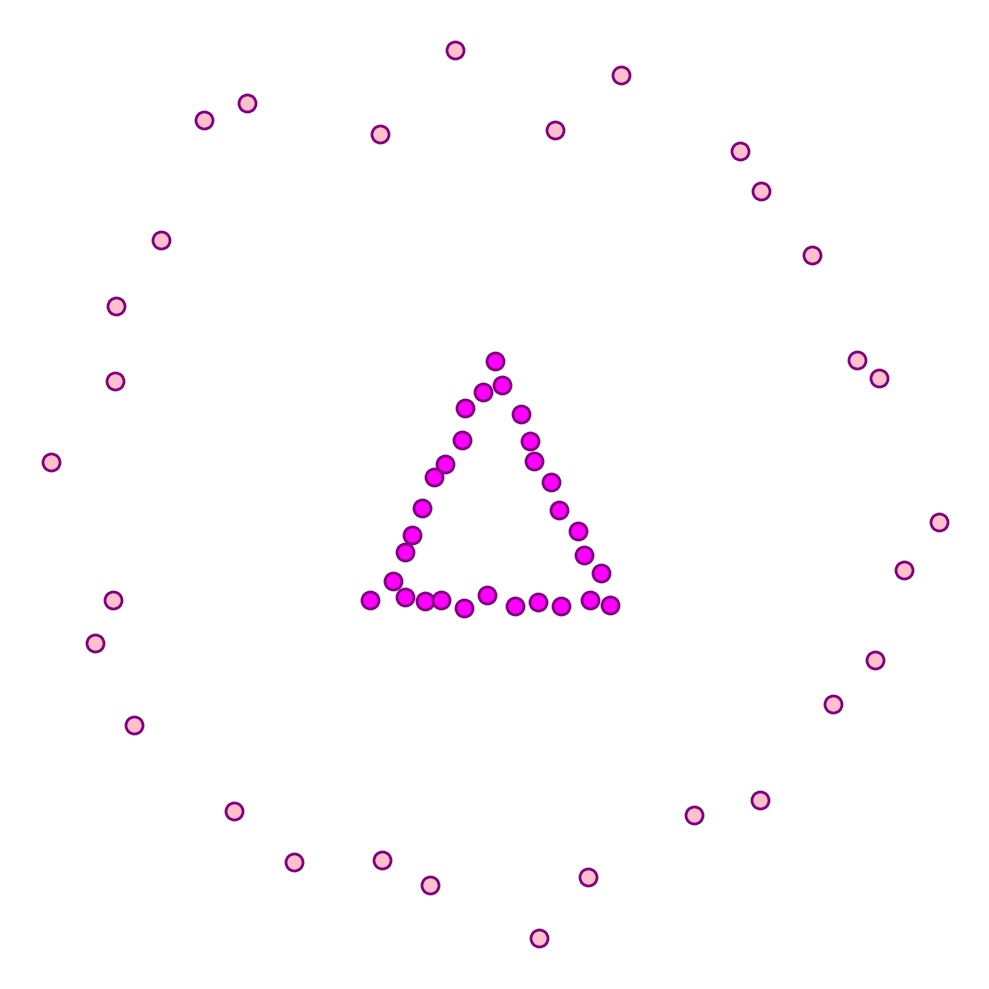

In [2]:
def generate_gaussian_points(q, a, c):
    return a * np.random.randn(2, q) + np.transpose(np.tile(c, (q, 1)))

# Parameters
n = 30

# Generate random points
X = np.random.randn(2, n) * 0.3
Y = np.hstack((generate_gaussian_points(int(n/2), 0.5, [0, 1.6]),
               np.hstack((generate_gaussian_points(int(n/4), 0.3, [-1, -1]),
                          generate_gaussian_points(int(n/4), 0.3, [1, -1])))))

# Define the vertices of the triangle
vertex1 = np.array([-np.sqrt(3)/6, -np.sqrt(3)/6])
vertex2 = np.array([np.sqrt(3)/6, -np.sqrt(3)/6])
vertex3 = np.array([0, np.sqrt(3)/6])

# Number of points on each edge
num_points_per_edge = 10

# Generate points on the edges with random noise
edge1_points = np.linspace(vertex1, vertex2, num_points_per_edge, endpoint=False) + np.random.randn(2, num_points_per_edge).T * 1e-2
edge2_points = np.linspace(vertex2, vertex3, num_points_per_edge, endpoint=False) + np.random.randn(2, num_points_per_edge).T * 1e-2
edge3_points = np.linspace(vertex3, vertex1, num_points_per_edge, endpoint=False) + np.random.randn(2, num_points_per_edge).T * 1e-2

# Combine points from all edges
X = np.vstack((edge1_points, edge2_points, edge3_points)).T

# Generate circular points
theta = np.linspace(0, 2*np.pi, n, endpoint=False)
Y = ([0, 0] + 1. * np.column_stack((np.cos(theta), np.sin(theta))) + np.random.randn(2, n).T * 6e-2).T

# # Shuffle points
# idxX = np.random.permutation(n)
# X = X[:, idxX]

# Plotting
plt.figure(figsize=(10, 10))
plot_points = lambda x, col: plt.scatter(x[0, :], x[1, :], s=150, edgecolors="purple", c=col, linewidths=2)
plot_points(X, 'magenta')
plot_points(Y, 'pink')
plt.axis("off")
plt.xlim(np.min(Y[0, :]) - 0.1, np.max(Y[0, :]) + 0.1)
plt.ylim(np.min(Y[1, :]) - 0.1, np.max(Y[1, :]) + 0.1)
plt.tight_layout()
plt.savefig("data_sinkhorn.pdf")
plt.show()

### Construct Kernel

In [78]:
p = 2
k = p

In [79]:
x2 = np.sum(X**2,0)
y2 = np.sum(X**2,0)
C = np.tile(y2, (n, 1)) + np.tile(x2[:,np.newaxis], (1, n)) - 2*np.dot(np.transpose(X), Y)
C = np.power(scipy.spatial.distance_matrix(x=X.T, y=Y.T, p=p), k)
C /= C.max()
C[C < .3] = 0
# C[C != 0] = 1.0

# print(C.max(axis=1))

a = np.ones(n)/n
b = np.ones(n)/n

epsilon_kernel = 1e-2
K = np.exp(-C/epsilon_kernel)
# K[K < 1] = 0.0
v = np.ones(n)

u = a / (np.dot(K,v))
v = b / (np.dot(np.transpose(K),u))

In [69]:
print((K == 0).sum())

282


In [81]:
print(K)

[[6.82670514e-37 6.04789700e-33 1.88386381e-34 5.84903034e-35
  1.67363433e-35 1.77766617e-37 2.18745317e-37 2.40998380e-28
  3.31682282e-34 3.75788158e-24 4.90005356e-29 1.18309422e-28
  1.56730128e-19 3.70001337e-17 1.00000000e+00 5.49657602e-14
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 3.67967843e-16
  3.43935869e-14 3.31970001e-17 9.74269063e-22 2.26910526e-25
  4.96078807e-29 4.41649427e-32]
 [1.33599562e-32 3.50080049e-29 1.57513477e-30 1.78450503e-31
  2.26386951e-32 1.77789355e-34 2.96166985e-35 9.28568535e-27
  2.49192110e-33 6.51040434e-24 8.54821616e-30 9.29992757e-30
  4.79119000e-21 4.66003188e-19 5.47968173e-15 1.72330219e-16
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 3.23851185e-15
  1.00000000e+00 5.48601532e-15 5.29801465e-19 5.14847623e-22
  2.52500318e-25 4.31782386e-28]
 [2.17586868e-30 1.88711916e-27 1.09583600e-28 5.12687358e-30
  3.

True


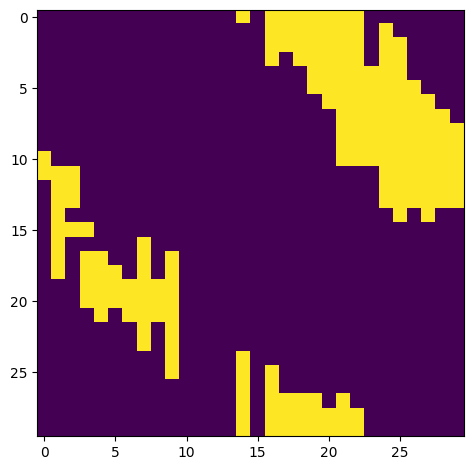

In [80]:
print(utils.is_balanceable(K))
plt.imshow(K)
plt.tight_layout()
plt.savefig("K.pdf")
plt.show()

In [71]:
epsilon = 1e-10

### Use Osborn

In [72]:
K_sparse = scipy.sparse.csr_array(K)
criterions_osborn = dict()
for method in ['greedy', 'cyclic', 'random', 'random_cyclic']:
    balancer = osborn.MatrixBalancer(matrix=K_sparse, epsilon=epsilon)
    _, it_osborn, criterions_osborn[method] = balancer.balance(method)

### Use Sinkhorn

In [73]:
criterions_sinkhorn = []
criterion = np.inf
iter = 3000
while criterion >= epsilon and iter:
    iter -= 1
    u = a / (np.dot(K,v))
    v = b /(np.dot(np.transpose(K),u))
    r = v*np.dot(np.transpose(K),u)
    s = u*np.dot(K,v)
    criterion = np.linalg.norm(r - s, 1)/ np.dot(np.dot(np.diag(u),K),np.diag(v)).sum()
    criterions_sinkhorn.append(criterion)

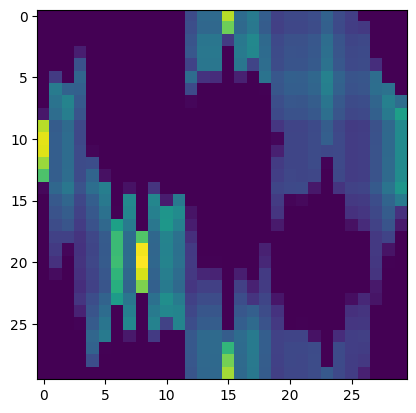

In [74]:
P = np.dot(np.dot(np.diag(u),K),np.diag(v))
plt.imshow(P);

### Plot results

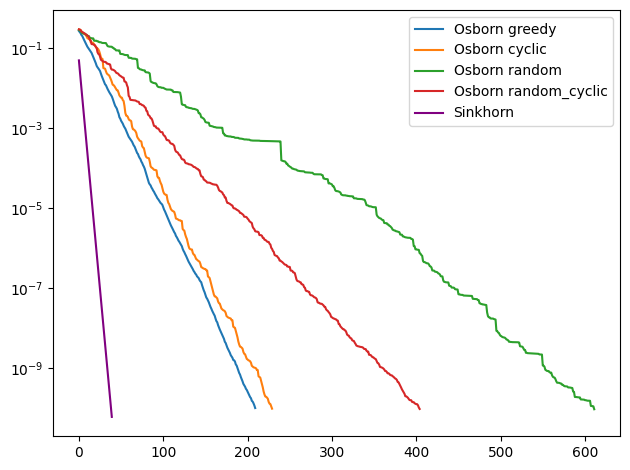

In [75]:
for method, criterions in zip(criterions_osborn, criterions_osborn.values()):
    plt.plot(criterions, label=f"Osborn {method}")
plt.plot(criterions_sinkhorn, color="purple", label="Sinkhorn")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.savefig(f"osborn_vs_sinkhorn_dist2_{epsilon_kernel}_{epsilon}_{p}_{k}.pdf")
plt.show()